In [1]:
import statistics
import torch
import torch.nn as nn
from torch.utils import data

import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
import data_loader

raw_dataset, tokens_vocab, y_vocab = data_loader.load_raw_data(S=100)

[nltk_data] Downloading package semcor to
[nltk_data]     /Users/urisherman/nltk_data...
[nltk_data]   Package semcor is already up-to-date!


In [3]:
idx = 1
print(raw_dataset['int_sentences'][idx])
print(raw_dataset['str_sentences'][idx])
print(raw_dataset['int_labels'][idx])
print(raw_dataset['str_labels'][idx])

[23, 24, 25, 5, 26, 27, 28, 29, 18, 30, 31, 32, 33, 34, 35, 36, 37, 9, 30, 14, 38, 30, 39, 40, 41, 9, 30, 31, 9, 10, 42, 30, 43, 26, 34, 30, 14, 44, 45]
['The', 'jury', 'further', 'said', 'in', 'term', 'end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', 'which', 'had', 'overall', 'charge', 'of', 'the', 'election', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted']
[4, 13, 14, 2, 4, 15, 16, 17, 4, 4, 1, 1, 1, 4, 18, 19, 20, 4, 4, 21, 22, 4, 23, 4, 24, 4, 4, 25, 25, 25, 4, 4, 26, 4, 4, 4, 21, 4, 27]
['no_sense', 'jury.n.01_jury', 'far.r.02_far', 'state.v.01_say', 'no_sense', 'term.n.02_term', 'end.n.02_end', 'presentment.n.01_presentment', 'no_sense', 'no_sense', 'group.n.01_group', 'group.n.01_group', 'group.n.01_group', 'no_sense', 'own.v.01_have', 'overall.s.02_overall', 'mission.n.03_charge', 'no_sense', 'no_sense', 'election.n.01_election', 'deserve.v.01

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cpu')

In [5]:
class WSDModel(nn.Module):
    def __init__(self, V, Y, D=300):
        super(WSDModel, self).__init__()
        self.E_v = nn.Parameter(torch.randn(V, D, requires_grad=True, device=device))
        self.E_y = nn.Parameter(torch.randn(Y, D, requires_grad=True, device=device))
        self.W_A = nn.Parameter(torch.randn(D, D, requires_grad=True, device=device))
        self.W_O = nn.Parameter(torch.randn(D, D, requires_grad=True, device=device))

    def attention(self, X, Q):
        a = torch.nn.Softmax(dim=2)(Q @ self.W_A @ X.permute(0, 2, 1))
        return a @ X @ self.W_O
    
    def forward(self, M_s, M_q):
        X = M_s @ self.E_v
        Q = M_q @ self.E_v

        Q_c = self.attention(X, Q)
        H = F.relu(Q_c + Q)
        y_logits = (H @ self.E_y.T).squeeze()
        return y_logits

In [6]:
V = tokens_vocab.size()
Y = y_vocab.size()

model = WSDModel(V, Y, D=300)
print(f'V={V}, Y={Y}')

In [7]:
wsd_dataset = data_loader.WSDDataset(raw_dataset, V, N=100)
training_generator = data.DataLoader(
    wsd_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=4
)

In [8]:
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

losses = []
for epoch in range(1):
    with tqdm(training_generator) as prg_train:
        for M_s, M_q, y_true in prg_train:
            M_s, M_q, y_true = M_s.to(device), M_q.to(device), y_true.to(device)

            ## SHAPES:
            # M_s     --> [B, N, V]
            # M_q     --> [B, 1, V]
            # y_true  --> [B]
            
            optimizer.zero_grad()

            y_logits = model.forward(M_s, M_q)

            loss = ce_loss(y_logits, y_true)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            running_mean_loss = statistics.mean(losses[-min(len(losses), 1000):])
            status_str = f'[{epoch}] loss: {running_mean_loss:.3f}'
            prg_train.set_description(status_str)

[0] loss: 429.640: 100%|██████████| 35/35 [00:02<00:00, 13.98it/s]


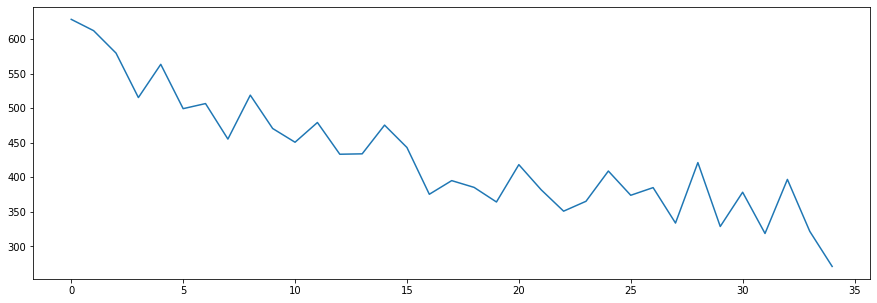

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))

plt.plot(losses, '-');